In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CSC522_Final_Project'

/content/drive/MyDrive/CSC522_Final_Project


In [ ]:
!ls

 archive.zip	        enron_spam_data.zip	    spam_ham_dataset.csv    spam_subject_corpus
 enron_spam_data.csv    ham_subject_corpus	    spam_ham_dataset.xlsx   x_train_tsne
 enron_spam_data.xlsx  'spam_ham_dataset(1).xlsx'   spam_message_corpus


In [ ]:
#Import all libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
import gensim

import pickle
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#import all models here
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [ ]:
#Reading dataset
df = pd.read_csv("enron_spam_data.csv")

In [ ]:
print(df.head(10))

   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   
5           5      mcmullen gas for 11 / 99   
6           6         meter 1517 - jan 1999   
7           7           duns number changes   
8           8                    king ranch   
9           9        re : entex transistion   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14  
5  jackie ,\nsince the inl

In [ ]:
label= df["Spam/Ham"].value_counts()
print(label)

spam    17171
ham     16545
Name: Spam/Ham, dtype: int64


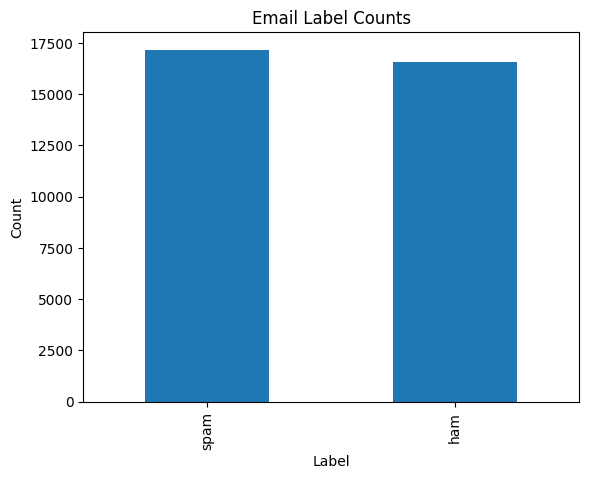

In [ ]:
#plot label counts
label.plot.bar()
plt.title("Email Label Counts")
plt.xlabel("Label")
plt.ylabel("Count")
#show the number over the bar
plt.show()

In [ ]:
# convert all text to lowwer case
df['Subject'] = df['Subject'].str.lower()
df['Message'] = df['Message'].str.lower()


In [ ]:
df.head(5)

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [ ]:
#preprocessing to remove punctuations and words like re : from subject and message
df['Subject'].fillna('', inplace=True)
df['Message'].fillna('', inplace=True)
df['Subject'] = df['Subject'].str.replace('[^\w\s]', '', regex=True)
df['Message'] = df['Message'].str.replace('[^\w\s]', '', regex=True)

In [ ]:
# Combining 'Subject' and 'Message' into a single column
df['text'] = df['Subject'] + ' ' + df['Message']

In [ ]:
# Assuming df is your DataFrame containing the 'text' column
# Tokenize the 'text' column and create a new column 'tokenized_text' to store the tokenized data
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x))
df['tokenized_subject'] = df['Subject'].apply(lambda x: word_tokenize(x))
df['tokenized_message'] = df['Message'].apply(lambda x: word_tokenize(x))

In [ ]:
label= df["Spam/Ham"].value_counts()
print(label)
s, h = label[0], label[1]
t = s+h
class_weight = {1:t/s , 0:t/h }

spam    17171
ham     16545
Name: Spam/Ham, dtype: int64


In [ ]:
#add any stop words we might see in the wordcloud
more_stopwords = {'re' , 's', 'fw', 'enron', 'subject', 'e', 'u'}
STOPWORDS = STOPWORDS.union(more_stopwords)

In [ ]:
df.head(5)

,Message ID,Subject,Message,Spam/Ham,Date,text,tokenized_text,tokenized_subject,tokenized_message
0,0,christmas tree farm pictures,,ham,1999-12-10,christmas tree farm pictures,"[christmas, tree, farm, pictures]","[christmas, tree, farm, pictures]",[]
1,1,vastar resources inc,gary production from the high island larger b...,ham,1999-12-13,vastar resources inc gary production from t...,"[vastar, resources, inc, gary, production, fro...","[vastar, resources, inc]","[gary, production, from, the, high, island, la..."
2,2,calpine daily gas nomination,calpine daily gas nomination 1 doc,ham,1999-12-14,calpine daily gas nomination calpine daily ga...,"[calpine, daily, gas, nomination, calpine, dai...","[calpine, daily, gas, nomination]","[calpine, daily, gas, nomination, 1, doc]"
3,3,re issue,fyi see note below already done \nstella\n ...,ham,1999-12-14,re issue fyi see note below already done \n...,"[re, issue, fyi, see, note, below, already, do...","[re, issue]","[fyi, see, note, below, already, done, stella,..."
4,4,meter 7268 nov allocation,fyi \n forwarded by lauri...,ham,1999-12-14,meter 7268 nov allocation fyi \n ...,"[meter, 7268, nov, allocation, fyi, forwarded,...","[meter, 7268, nov, allocation]","[fyi, forwarded, by, lauri, a, allen, hou, ect..."


In [ ]:
#TFID PARAMETRS CHNAGE HERE
max_features=1000

In [ ]:
# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, norm='l2', stop_words=list(STOPWORDS))

In [ ]:
#Train and Test split
X = df['text']
y = df['Spam/Ham']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.transform(y_test)
print('Encoder classes ', Encoder.classes_)

Encoder classes  ['ham' 'spam']


In [ ]:
#Embedding the train and test set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

RF classifier code

In [ ]:

rf = RandomForestClassifier(n_estimators= 200, class_weight=class_weight)
rf_model = rf.fit(X_train_tfidf, y_train)

In [ ]:
# Use the trained model to make predictions on the test data
rfc_y_pred = rf_model.predict(X_test_tfidf)

In [ ]:

rfc_precision = precision_score(y_test, rfc_y_pred)
rfc_recall = recall_score(y_test, rfc_y_pred)
rfc_accuracy = accuracy_score(y_test, rfc_y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(rfc_precision, 7), round(rfc_recall, 7), round(rfc_accuracy, 7)))

Precision: 0.9732589 / Recall: 0.97853 / Accuracy: 0.9752842


SVM Code

In [ ]:
#Creating and training the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1, class_weight=class_weight)
svm_classifier.fit(X_train_tfidf, y_train)

SVC(C=1, class_weight={0: 2.0378362042913265, 1: 1.963543183274125})

In [ ]:
#making predictions using test data
svm_y_pred = svm_classifier.predict(X_test_tfidf)

In [ ]:
#evaluating the SVM classifier
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test, svm_y_pred)
svm_recall = recall_score(y_test, svm_y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(svm_precision, 7), round(svm_recall, 7), round(svm_accuracy, 7)))

Precision: 0.986741 / Recall: 0.9932302 / Accuracy: 0.9897182


In [ ]:
print(confusion_matrix(y_test, svm_y_pred))

[[4876   69]
 [  35 5135]]


KNN classifier

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
#PCA for SVM
pca = TruncatedSVD(n_components=750)
X_train_tfidf_pca = pca.fit_transform(X_train_tfidf)
X_test_tfidf_pca = pca.transform(X_test_tfidf)
print(pca.explained_variance_.sum())

0.9019235869690991


In [ ]:
#KNN HYPERPARAMETERS
neighbors = 10
dist_metric = 'cosine'


In [ ]:
#creating and training the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=neighbors, metric=dist_metric)
knn_classifier.fit(X_train_tfidf_pca, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10)

In [ ]:
#making predictions using test data
knn_y_pred = knn_classifier.predict(X_test_tfidf_pca)

In [ ]:
# Evaluate the KNN classifier
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(knn_precision, 7), round(knn_recall, 7), round(knn_accuracy, 7)))

Precision: 0.9471163 / Recall: 0.9560928 / Accuracy: 0.9502719


NB Classifier

In [ ]:

classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
#Make predictions using test data
nb_y_pred = classifier.predict(X_test_tfidf)

In [ ]:
# Evaluate the classifier
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred)
nb_recall = recall_score(y_test, nb_y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(nb_precision, 7), round(nb_recall, 7), round(nb_accuracy, 7)))

Precision: 0.9764773 / Recall: 0.9876209 / Accuracy: 0.9815126


In [ ]:
#performing PCA with 2 components
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

In [ ]:
print(Encoder.classes_)
print(Encoder.transform(['spam', 'ham']))

['ham' 'spam']
[1 0]


In [ ]:
print(confusion_matrix(y_test, knn_y_pred))

[[2638 2307]
 [  21 5149]]
